In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
from racecar.SDRaceCar import SDRaceCar

np.set_printoptions(precision=4, suppress=True)

In [2]:
def getObservation():
    '''
    Returns observations from env
    :rtype: [x, y, theta], [x_dot, y_dot, theta_dot], h
    '''
    obs = env.get_observation()
    return obs[0:3], obs[3:6], obs[6]

def mapToRange(t, fromRange, toRange):
    '''
    Maps input t from range [a,b] to [c,d]
    '''
    assert isinstance(fromRange, tuple) and len(fromRange) == 2
    assert isinstance(toRange, tuple) and len(toRange) == 2
    assert isinstance(t, (int, float))
    
    a, b = fromRange
    c, d = toRange
    f_t = c + ((d-c)/(b-a))*(t-a)
    
    # Clipping if f_t exceeds range [c, d]
    if f_t < c: f_t = c
    if f_t > d: f_t = d
    
    return f_t

def getAction(Kp, Kd, verbose=False):
    '''
    Calculate required thrust and wheel angle to navigate car
    :rtype: np.array of size (2,)
    '''
    pos, vel, h = getObservation()
    x_desired, y_desired = h[0], h[1]
    x, y, theta = pos[0], pos[1], pos[2]
    vx, vy = vel[0], vel[1]
    delta_x, delta_y = x_desired - x, y_desired - y
    sx, sy = np.sign(delta_x), np.sign(delta_y)
    
    gamma = np.arctan2(delta_y, delta_x) - theta
    # Angle wrap around check
    if sx == -1 and sy == -1 and not(-np.pi/2 <= gamma <= np.pi/2): #3rd quadrant
        gamma += 2*np.pi
    if sx == -1 and sy == 1 and not(-np.pi/2 <= gamma <= np.pi/2): #2nd quadrant
        n = np.ceil(abs(gamma) / (2*np.pi))
        gamma -= (2*n*np.pi)
    
    #Control
    v_desired = np.sqrt( (delta_x**2 + delta_y**2)/np.cos(gamma)**2 )
    v_actual = np.sqrt(vx**2 + vy**2)
    thrust = (Kp * np.sqrt((delta_x**2 + delta_y**2))) + (Kd * (v_desired - v_actual))
    thrust_normalized = mapToRange(thrust, (0,20), (-1,1))
    angle = mapToRange(gamma, (-np.pi/2, np.pi/2), (-1,1))
    
    if verbose:
        print('x, y,  delta_x, delta_y, angle = ', np.sign(delta_x), np.sign(delta_y), delta_x, delta_y, angle*(180.0/np.pi))
    
    return np.array([angle, thrust_normalized]) #size (2,)

def getMSE(desiredTraj, actualTraj):
    '''
    Calculate mean squared error between two paths
    :rtype: float
    '''
    assert isinstance(desiredTraj, np.ndarray) and isinstance(actualTraj, np.ndarray)
    assert desiredTraj.shape[1] == 2
    assert desiredTraj.shape == actualTraj.shape
    squared_diff = np.sum(np.square(desiredTraj - actualTraj), axis=1)
    return np.mean(squared_diff)

Steps taken = 403
MSE between actual and desired trajectories =  9.361375979211653


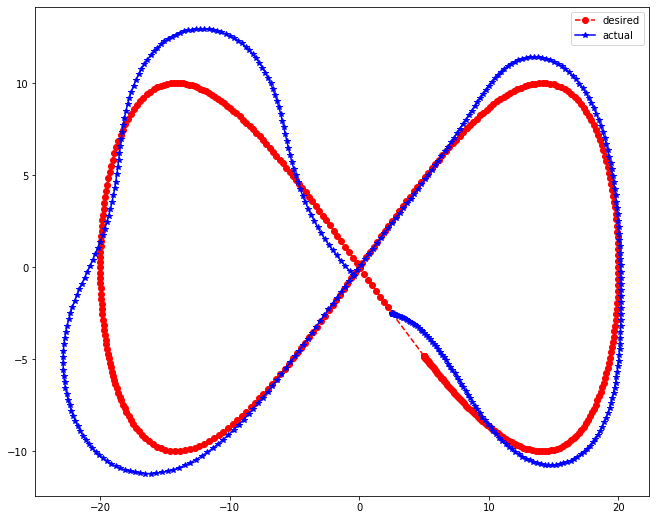

In [4]:
tracks = ['Linear', 'Circle', 'FigureEight']
env = SDRaceCar(render_env=False, track=tracks[2]) #change track here
state = env.reset()
previous_ind = 0
steps = 0
done = False

plot_track = True
env.x, env.y = state[-1]
actual_traj, desired_traj = [state[-1]], [state[-1]]

while not done:
    action = getAction(Kp = 1.05, Kd = 0.33, verbose=False)
    obs,r,done = env.step(action)
    steps +=1
    current_ind = env.closest_track_ind
    # CONDITION TO CHECK lap-completion
    if current_ind - previous_ind<=-500:
        done = True
    previous_ind = current_ind
    actual_traj.append([obs[0], obs[1]])
    desired_traj.append(list(obs[6]))

desired_traj, actual_traj = np.array(desired_traj), np.array(actual_traj)
print('Steps taken = {0}'.format(steps))
print('MSE between actual and desired trajectories = ', getMSE(desired_traj, actual_traj))

if plot_track:
    fig, ax = subplots(figsize=(11, 9))
    desired_traj, actual_traj = np.array(desired_traj), np.array(actual_traj)
    ax.plot(desired_traj[:,0], desired_traj[:,1], 'or--')
    ax.plot(actual_traj[:,0], actual_traj[:,1], '*-b')
    ax.legend(('desired','actual'),loc='best')
    plt.show()
    
# Kp = 1.15, Kd = 0.5 - works for eight
# Kp = 0.8, Kd = 0.1 - works for circle

# Kp = 1.25, Kd = 0.5 - works for both
# Kp = 1.05, Kd = 0.33 - works for both